In [1]:
from preprocessing_utils import load_all_files, preprocess_documents
from pathlib import Path
import os
from api import GOOGLE_API_KEY
# import google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
# genai.configure(api_key=GOOGLE_API_KEY)

c:\Users\mikel\Documents\GitHub\multimodal-rag\.venv\Lib\site-packages\deepeval\__init__.py:54: UserWarning: You are using deepeval version 2.7.1, however version 2.7.2 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


## Text only

In [ ]:
papers_path = Path("papers/selection")
docs = load_all_files(papers_path)
docs = preprocess_documents(docs) 

In [2]:
from langchain_core.prompts import PromptTemplate

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use around three sentences for your answer and keep it concise.
Do not ever mention that you are using the context as source.

Question: {question}

Context:
{context}

Answer:"    
"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [3]:
# from langchain import hub
# from langchain_chroma import Chroma
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from qdrant_client import models
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate


# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# splits = text_splitter.split_documents(docs)
qdrant_client = QdrantClient(path="papers_db")
# qdrant_client.create_collection(
#     collection_name="selection",
#     vectors_config=models.VectorParams(
#         size=768,
#         distance=models.Distance.COSINE
#     )

# )
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
# vectorstore = Chroma.from_documents(
#     documents=splits,
#     embedding=embeddings,
#     persist_directory="selection_db"
#  )
# vectorstore = Chroma(
#     persist_directory="selection_db",
#     embedding_function=embeddings
# )
vectorstore = QdrantVectorStore(
    client=qdrant_client,
    collection_name="selection",
    embedding=embeddings,
    distance=models.Distance.COSINE
)
# vectorstore.add_documents(docs)

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever(
    search_kwargs={"k": 3}
)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite")
prompt = custom_rag_prompt


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# rag_chain = (
#     {"context": retriever | format_docs, "question": RunnablePassthrough()}
#     | prompt
#     | llm
#     | StrOutputParser()
# )

# rag_chain.invoke("What is Task Decomposition?")
system_prompt = (
    "You are an assistant for question-answering tasks."
    "Use the following pieces of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know."
    "Use around three sentences for your answer and keep it concise."
    "Use LaTeX to format any math equation."
    "Do not ever mention that you are using the context as source."
    "Here is context for your answer:"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# rag_chain.invoke({"input": "What kind of material is MAPbI3?"})

In [4]:
response = rag_chain.invoke({"input":
"Give me an example architecture of a graph neural network used to predict physical properties of crystals and describe the internal architecture."
                             })
print(response["context"])
print(response["answer"])

[Document(metadata={'producer': 'iText® 5.3.5 ©2000-2012 1T3XT BVBA (SPRINGER SBM; licensed version)', 'creator': 'Springer', 'creationdate': '2021-08-31T00:12:39+05:30', 'keywords': '', 'crossmarkdomains[1]': 'springer.com', 'moddate': '2021-08-31T07:48:08+02:00', 'subject': 'Communications Materials, doi:10.1038/s43246-021-00194-3', 'doi': '10.1038/s43246-021-00194-3', 'author': 'Jiucheng Cheng', 'crossmarkdomains[2]': 'springerlink.com', 'title': 'A geometric-information-enhanced crystal graph network for predicting properties of materials', 'source': 'papers/selection/Cheng et al. - 2021 - A geometric-information-enhanced crystal graph net.pdf', 'total_pages': 11, 'page': 1, 'page_label': '2', '_id': '36825661a76a4aec975a0d94df1f33c1', '_collection_name': 'selection'}, page_content='aggregation process. In material prediction domain, the geometrical Crystal graph deﬁ nition and the introduction of geometric\nstructure information like spatial distance and direction is alsoinformati

In [4]:
from preprocessing_utils import load_queries, load_answers

queries = load_queries("papers/selection_queries.txt")
answers = load_answers("papers/selection_answers.txt")

In [6]:
paper_names = sorted(os.listdir("papers/selection"), key=lambda x: int(x.split("_")[0]))
paper_names

['1_helical_weyl.pdf',
 '2_magic_angle.pdf',
 '3_chiral_kagome.pdf',
 '4_quantum_supremacy.pdf',
 '5_wte2.pdf',
 '6_fgt.pdf',
 '7_kagome_order.pdf',
 '8_triangulene.pdf',
 '9_neutron_activation.pdf',
 '10_rucl3.pdf',
 '11_methylammonium.pdf',
 '12_perovskites.pdf',
 '13_high_troughput.pdf',
 '14_quenched_nematic.pdf',
 '15_fractional_charges.pdf',
 '16_plasmons.pdf',
 '17_charge_transfer.pdf',
 '18_photonic_axion.pdf',
 '19_adsorption.pdf',
 '20_cgnn.pdf']

In [2]:
from metrics import compute_dcg
import numpy as np
ideal_dcg = compute_dcg(["a", "a", "a"], np.array([1,1,1]), "a")
ideal_dcg

np.float64(2.1309297535714578)

In [ ]:
scores = []
for questions, gold_name in zip(queries, paper_names):
    for query in questions:
        result = vectorstore.similarity_search_with_score(query)
        retrieved_docs = [x[0] for x in result]
        retrieved_scores = np.array([x[1] for x in result])
        retrieved_names = [Path(doc.metadata["source"]).name for doc in retrieved_docs]
        scores.append(compute_dcg(retrieved_names, retrieved_scores, gold_name) / ideal_dcg)
scores = np.array(scores)
scores

array([0.90325211, 0.8043681 , 0.8931873 , 0.77793567, 0.90191179,
       0.85582628, 0.73910535, 0.87486064, 0.87178229, 0.76854813,
       0.75890711, 0.78719071, 0.66802446, 0.67354001, 0.83462882,
       0.63187465, 0.80785569, 0.87585578, 0.29583043, 0.32937405,
       0.63691264, 0.8279142 , 0.81288415, 0.3173956 , 0.73844581,
       0.73137116, 0.764208  , 0.87312454, 0.82169079, 0.87638703,
       0.84600412, 0.89798883, 0.79308244, 0.83783709, 0.80531714,
       0.75374734, 0.71420121, 0.        , 0.26868167, 0.8270814 ,
       0.82533922, 0.85486909, 0.91052406, 0.7836308 , 0.82682394,
       0.80297807, 0.8536215 , 0.81635612, 0.88188953, 0.68063833,
       0.89962569, 0.80594209, 0.82717863, 0.47147366, 0.80714767,
       0.7986099 , 0.86533019, 0.77911123, 0.85701513, 0.72357773])

In [ ]:
doc_max_page = {}
for doc in docs:
    doc_max_page[Path(doc.metadata["source"]).name] = doc.metadata["total_pages"]

doc_max_page

{'10_rucl3.pdf': 12,
 '11_methylammonium.pdf': 7,
 '12_perovskites.pdf': 13,
 '13_high_troughput.pdf': 9,
 '14_quenched_nematic.pdf': 7,
 '15_fractional_charges.pdf': 20,
 '16_plasmons.pdf': 14,
 '17_charge_transfer.pdf': 11,
 '18_photonic_axion.pdf': 12,
 '19_adsorption.pdf': 10,
 '1_helical_weyl.pdf': 10,
 '20_cgnn.pdf': 11,
 '2_magic_angle.pdf': 13,
 '3_chiral_kagome.pdf': 19,
 '4_quantum_supremacy.pdf': 7,
 '5_wte2.pdf': 6,
 '6_fgt.pdf': 10,
 '7_kagome_order.pdf': 7,
 '8_triangulene.pdf': 6,
 '9_neutron_activation.pdf': 8}

In [28]:
qrel = {}
query_index = 1

for group_index, questions in enumerate(queries):
    for query in questions:
        query_dict = qrel.setdefault(f"q{query_index}", {})
        query_index += 1
        for doc_index, doc_name in enumerate(paper_names):
            for page_num in range(doc_max_page[doc_name]):
                query_dict[f"{doc_name}_{page_num + 1}"] = 1 if group_index == doc_index else 0

In [29]:
run = {}
query_index = 1
for questions, gold_name in zip(queries, paper_names):
    for query in questions:
        query_dict = run.setdefault(f"q{query_index}", {})
        query_index += 1
        result = vectorstore.similarity_search_with_score(query, k=1e6)
        for point, score in result:
            doc_name = Path(point.metadata["source"]).name
            page_num = point.metadata["page"]
            query_dict[f"{doc_name}_{page_num+1}"] = score

In [30]:
import json

json.dump(run, open("run_text.json", "w"), indent=4)

## Multimodal

In [6]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite")

In [7]:
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import HumanMessage, SystemMessage
import base64

# Function to encode an image as base64
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")

# Encode the image(s)
image_path = "image.jpg"  # Replace with your image path
image_base64 = encode_image(image_path)

# Define system message (instructions for the AI)
system_template = "You are an AI assistant that analyzes images and answers user queries."
system_message = SystemMessagePromptTemplate.from_template(system_template)

# Define human message (text + image context)
human_template = "{text}"  # Placeholder for user input text
human_message = HumanMessagePromptTemplate.from_template(human_template)

# Create the chat prompt template
chat_prompt = ChatPromptTemplate.from_messages([system_message, human_message])

# Format the chat prompt with user input
formatted_prompt = chat_prompt.format_messages(
    text="What can you tell me about this image?",
)

# Append image to the human message dynamically
formatted_prompt.append(
    HumanMessage(
        content=[
            {"type": "text", "text": "Here is the image context:"},
            {"type": "image_url", "image_url": f"data:image/jpeg;base64,{image_base64}"}
        ]
    )
)

# Initialize Gemini model (multimodal)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Get the response from the model
response = llm(formatted_prompt)
print(response.content)

/var/folders/9w/3l6rxjcs3bgfl3v7b2f66llr0000gn/T/ipykernel_77878/2457562682.py:44: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(formatted_prompt)


The image features a tabby cat wearing orange sunglasses. The cat has green eyes and a white chest. It's sitting on what appears to be a sofa, with various cushions visible in the background. The image is well-lit and has a shallow depth of field, focusing attention on the cat's face.


In [ ]:
from langchain_core.runnables import RunnableLambda

top_k = 2

def retrieve_images(query):
    return [encode_image("image.jpg") for i in range(top_k)]

def print_thing(thing):
    print(thing)
    return thing

def expand_context_images(message):
    new_message = {}
    new_message["query"] = message["query"]
    for i, image in enumerate(message["context_images"]):
        new_message[f"context{i}"] = image
    
    return new_message

system_message = (
    "You are an assistant for question-answering tasks."
    "Use the images of retrieved context to answer the question."
    "If you don't know the answer, just say that you don't know."
    "Use around three sentences for your answer and keep it concise."
    "Do not ever mention that you are using the context as source."
) 

user_message = [
    {
        "type": "text",
        "text": "{query}",
    }
] + [
    {
        "type": "image_url",
        "image_url": {"url": "data:image/jpeg;base64,{placeholder}".replace("placeholder", f"context{i}")},
    }
    for i in range(top_k)
]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        (
            "user",
            user_message,
        ),
    ]
)
# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_message),
#         (
#             "user",
#             [
#                 {
#                     "type": "text",
#                     "text": "{query}",

#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {"url": "data:image/jpeg;base64,"},
#                 }
#             ],
#         ),
#     ]
# )

rag_chain = (
    {"context_images": retrieve_images, "query": RunnablePassthrough()}
    | RunnableLambda(expand_context_images)
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What are these images? Are they the same?")

'The images show a cat wearing orange sunglasses. Yes, they are the same.'

In [42]:
prompt

ChatPromptTemplate(input_variables=['context0', 'context1', 'query'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks.Use the images of retrieved context to answer the question.If you don't know the answer, just say that you don't know.Use around three sentences for your answer and keep it concise.Do not ever mention that you are using the context as source."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['query'], input_types={}, partial_variables={}, template='{query}'), ImagePromptTemplate(input_variables=['context0'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{context0}'}), ImagePromptTemplate(input_variables=['context1'], input_types={}, partial_variables={}, template={'url': 'data:image/jpeg;base64,{context1}'})], additional_kwargs={}

## Evaluation

In [4]:
# Only run this block for Gemini Developer API
# from google import genai
# genai_client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
from preprocessing_utils import load_queries, load_answers

queries = load_queries("papers/selection_queries.txt")
answers = load_answers("papers/selection_answers.txt")

In [5]:
from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric
from deepeval.test_case import LLMTestCase
from deepeval_utils import GenerativeGeminiModel, GeminiJudge
from deepeval.models.llms import GeminiModel

# Replace this with the actual output from your LLM application
actual_output = "I like trains."

judge_llm = GeminiModel(
    model_name="gemini-2.0-flash-lite",
    api_key=GOOGLE_API_KEY
)

metric = AnswerRelevancyMetric(
    threshold=0.7,
    model=judge_llm,
    include_reason=True
)
test_case = LLMTestCase(
    input="What if these shoes don't fit?",
    actual_output=actual_output
)

# To run metric as a standalone
# metric.measure(test_case)
# print(metric.score, metric.reason)

# result = evaluate(test_cases=[test_case], metrics=[metric])

In [7]:
rag_chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['QdrantVectorStore', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_qdrant.qdrant.QdrantVectorStore object at 0x000001E91E816420>, search_kwargs={'k': 3}), kwargs={}, config={'run_name': 'retrieve_documents'}, config_factories=[])
})
| RunnableAssign(mapper={
    answer: RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
              context: RunnableLambda(format_docs)
            }), kwargs={}, config={'run_name': 'format_inputs'}, config_factories=[])
            | ChatPromptTemplate(input_variables=['context', 'input'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks.Use the following pieces of retrieved context to answer the qu

In [8]:
from deepeval.dataset import EvaluationDataset
from preprocessing_utils import create_dataset


dataset = create_dataset(rag_chain, queries, answers)

Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming
Sleeping after 15 queries
Resuming


In [9]:
dataset.save_as(file_type="json", directory="papers/selection_gemini-2.0-flash-lite_text", include_test_cases=True)

Evaluation dataset saved at papers/selection_gemini-2.0-flash-lite_text\20250413_122238.json!


'papers/selection_gemini-2.0-flash-lite_text\\20250413_122238.json'

In [15]:
from deepeval.dataset import EvaluationDataset

DATASET_PATH = Path(r"papers\selection_gemini-2.0-flash-lite_vlm\20250413_104009.json")
dataset = EvaluationDataset()
dataset.add_test_cases_from_json_file(
    file_path=DATASET_PATH,
    input_key_name="input",
    actual_output_key_name="actual_output",
    expected_output_key_name="expected_output",
    context_key_name="context",
    retrieval_context_key_name="retrieval_context",
)

In [ ]:
from deepeval.metrics import AnswerRelevancyMetric
from time import sleep

answer_relevancy_metric = AnswerRelevancyMetric(threshold=0.5, model=judge_llm, include_reason=True)

results = []
batch_size = 5
test_case_index = 0
number_errors = 0
for i, test_case in enumerate(dataset.test_cases):
    try:
        result = evaluate(test_cases=[test_case], metrics=[answer_relevancy_metric])
    except AttributeError:
        print("Error in test case:", i)
        print("Continuing...")
        number_errors += 1
    results.append(result)
    if (i + 1) % batch_size == 0:
        print("Processed", i + 1, " test cases")
        sleep(65)

print(number_errors)


In [82]:
from deepeval.metrics import AnswerRelevancyMetric
from time import sleep

answer_relevancy_metric = AnswerRelevancyMetric(threshold=0.5, model=judge_llm, include_reason=True)

results = []
batch_size = 5
for i in range(0, len(dataset), batch_size):
    partial_dataset = EvaluationDataset(test_cases=dataset.test_cases[i:i+batch_size])
    partial_result = partial_dataset.evaluate([answer_relevancy_metric])
    results.append(partial_result)
    print(f"Sleeping for 70 seconds after processing {i+batch_size} queries")
    sleep(70)
    print("Resuming")

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:03,  1.66test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output is perfectly relevant and contains no irrelevant statements. Great job!, error: None)

For test case:

  - input: How is the superconductivity measured in a graphene superlattice?
  - actual output: Superconductivity in graphene superlattices is measured by observing zero-resistance states. This is achieved by electrostatic doping away from correlated insulating states. The critical temperature of the graphene superlattice is up to 1.7 kelvin.
  - expected output: Superconductivity is measured using a four-probe measurement scheme with voltage probes (Vxx, Vg), current (I), and bias voltage (Vbias). The electron density is tuned by a metal gate beneath the bottom hexagonal boron nitride layer.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 5 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:02,  1.69test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the input without any irrelevant information. Great job!, error: None)

For test case:

  - input: Explain the architecture in terms of qubits and adjustable copuplers of the Sycamore processor.
  - actual output: The Sycamore processor is a two-dimensional array of 54 transmon qubits. Each qubit is connected to its four nearest neighbors via adjustable couplers. These couplers allow for quick tuning of the qubit-qubit coupling.
  - expected output: The sycamore processor has 54 qubits in a rectangular array, each one coupled to its four nearest neighbors.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the que

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 10 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:03,  1.59test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: What is the speed-up gained by using a quantum processor instead of an equal-fidelity classical sampling algorithm?
  - actual output: The quantum processor takes 200 seconds to sample one instance of a quantum circuit a million times. An equal-fidelity classical sampling algorithm would take approximately 10,000 years on a million cores. This represents a dramatic speedup achieved by the quantum processor.
  - expected output: For $m=20$ number of cycles and $n=53$ qubits, obtaining a million samples on the quantum processor takes 200 seconds, whereas an equal-fidelity classical sampling would take 10,000 years on a million cores.
  - context: None
  - retrieval context: None


Metrics Summary

 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 15 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:03,  1.56test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: What is the unit cell of CsVe3Sb5 and the space group?
  - actual output: The unit cell of CsV3Sb5 is described as individual sublattices of a kagome network of V coordinated by Sb1 atoms and a hexagonal net of Sb2. The space group of CsV3Sb5 is P6/mmm. This information is derived from the provided context.
  - expected output: CsV3Sb5 has the symmetry of space group P6/mmm. The unit cell is described as individual sublattices of a kagome netwwork of V coordinated by Sb1 atoms and a hexagonal net of Sb2 above and below each kagome layer.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-f

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 20 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:03,  1.62test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: What is the relation between the bias voltage in triangulene (TNS) and its conductance?
  - actual output: The dI/dV spectrum on a triangulene unit of a TNS shows inelastic steps at specific bias voltages. These steps are related to the excitation of collective spin states within the triangulene ring. The position and height of these steps provide information about the spin excitation spectrum.
  - expected output: The conductance shows a dip at zero bias voltage and bias-symmetric step-like features which are characteristic of spin excitation induced by inelastic electron tunneling.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 25 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:02,  1.71test case/s]




Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output is perfectly relevant and contains no irrelevant statements. Great job!, error: None)

For test case:

  - input: What is typical behavior of the nuetron flux from a compact source with respect to distance to the source?
  - actual output: The neutron flux from a compact source decreases with the square of the distance from the source. This means the flux scales as $d^{-2}$, where $d$ is the distance. For instance, at a position of 3.8 cm from the source, the flux is approximately $10^7 \text{ cm}^{-2}\text{ s}^{-1}$.
  - expected output: The neutron flux diminishes with the square of distance from the sample to the source.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 30 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:03,  1.36test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: How does th magnetization M of the Co2+ atoms vary in EDACoCl4 with respect to temperature?
  - actual output: The temperature-dependent magnetization (M) of EDACoCl4 is presented in the provided figures. The magnetization is measured at 500 Oe parallel and perpendicular to the [CoCl4]2− tetrahedra layers. The figures show how the magnetization varies with temperature for EDACoCl4.
  - expected output: The magnetization increasing from 0K and peaks at approximately 13K, the it decreases expontentially.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 35 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:02,  1.86test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: How many enforced semimetals are there for the compounds with magnetic space group (MSG) 51.298?
  - actual output: For compounds with magnetic space group (MSG) 51.298, the context indicates there is one enforced semimetal for each value of U = 0, 2, and 4 eV. The table provides the number of enforced semimetals/ESFDs for different values of U. This information is found in Table 1.
  - expected output: There are 0 or 1 enforced semimetals with the magnetic space group symmetry of 51.298, depending on the value of the U parameter.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-li

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 40 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:02,  1.77test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly answers the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: Does FeSe support a spin density wave (SDW) at any pressure or temperature?
  - actual output: The provided context does not explicitly state whether FeSe supports a spin density wave (SDW) at any pressure or temperature. It does mention that magnetic order is expected at high pressures exceeding 40 kbar, but does not confirm the presence of a SDW. Therefore, I cannot answer the question.
  - expected output: No, the spin-density wave (SDW) phase only exists for some ranges of pressure and temperature, approximately from 30 to 80kbar and from 0 to 40K.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model:

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 45 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:02,  1.69test case/s]



Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, reason: The score is 1.00 because the output perfectly addresses the question without any irrelevant information. Great job!, error: None)

For test case:

  - input: What is the charge density wave (CDW) in heterostructures of T and H transition metal dichalcogenides?
  - actual output: The √ 13×√ 13 charge density wave (CDW) state in the T polytype of MX2 (M = Nb, Ta, X = S, Se) hosts a half-filled flat band. This flat band is driven into a Mott insulating state by electronic correlations. When T polytypes are coupled to H polytypes, charge transfer can destabilize the Mott state.
  - expected output: The heterostructures show a $\sqrt{13}\times\sqrt{13}$ CDW with a Star of David shape.
  - context: None
  - retrieval context: None


Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.5, strict: False, evaluation model: gemini-2.0-flash-lite, re

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Sleeping for 70 seconds after processing 50 queries
Resuming


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.0-flash-lite, strict=False, 
async_mode=True)...

Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:38,  9.72s/test case]


AttributeError: 'NoneType' object has no attribute 'statements'

In [17]:
import pickle
pickle.dump(results, open(DATASET_PATH.parent / "answer_relevancy.pkl", "wb"))

In [18]:
pickle.load(open(DATASET_PATH.parent / "answer_relevancy.pkl", "rb"))

[EvaluationResult(test_results=[TestResult(name='test_case_0', success=True, metrics_data=[MetricData(name='Answer Relevancy', threshold=0.5, success=True, score=1.0, reason='The score is 1.00 because the output perfectly answers the question without any irrelevant information. Great job!', strict_mode=False, evaluation_model='gemini-2.0-flash-lite', error=None, evaluation_cost=0.0, verbose_logs='Statements:\n[\n    "EuCuAs has a helical and a DP-AFM crystal magnetic structure.",\n    "The helical structure is described by the propagation vector $q_m = (0, 0, 0.1)$ at the temperature $T = 2$ K.",\n    "The DP-AFM structure has a propagation vector $q_m = (0, 0, 0)$."\n] \n \nVerdicts:\n[\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    },\n    {\n        "verdict": "yes",\n        "reason": null\n    }\n]')], conversational=False, multimodal=False, input='What crystal magnetic structure does EuCuAs have?', 

In [39]:
from tqdm import tqdm

actual_embeddings = []
expected_embeddings = []
for test_case in tqdm(dataset.test_cases):
    actual_vector = embeddings.embed_query(test_case.actual_output)
    actual_embeddings.append(actual_vector)
    expected_vector = embeddings.embed_query(test_case.expected_output)
    expected_embeddings.append(expected_vector)

100%|██████████| 60/60 [00:29<00:00,  2.06it/s]


In [40]:
%load_ext autoreload
%aimport metrics
%autoreload 1

import numpy as np
from metrics import similarity_scores

scores = similarity_scores(actual_embeddings, expected_embeddings)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
scores.mean()

np.float64(0.775280121309187)

In [ ]:
# np.savetxt(DATASET_PATH.parent / "similarity_scores.dat", scores)

In [44]:
names = ["text", "vlm", "mixed", "text-lite", "vlm-lite", "mixed-lite"]
paths = [
    "papers/selection_gemini-2.0-flash_text",
    "papers/selection_gemini-2.0-flash_vlm",
    "papers/selection_gemini-2.0-flash_mixed",
    "papers/selection_gemini-2.0-flash-lite_text",
    "papers/selection_gemini-2.0-flash-lite_vlm",
    "papers/selection_gemini-2.0-flash-lite_mixed",
]

scores = {}
for name, path in zip(names, paths):
    scores.setdefault(name, np.loadtxt(Path(path) / "similarity_scores.dat"))

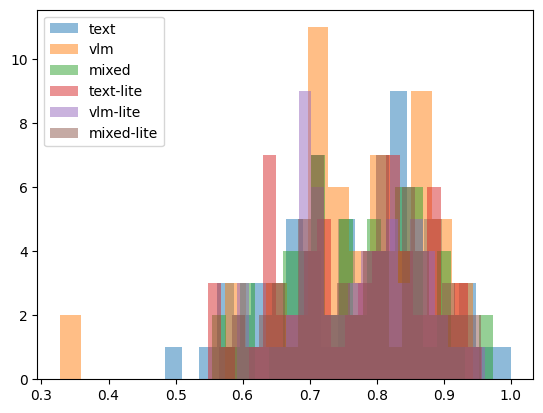

In [46]:
import matplotlib.pyplot as plt

plt.hist(scores["text"], bins=20, alpha=0.5, label="text")
plt.hist(scores["vlm"], bins=20, alpha=0.5, label="vlm")
plt.hist(scores["mixed"], bins=20, alpha=0.5, label="mixed")
plt.hist(scores["text-lite"], bins=20, alpha=0.5, label="text-lite")
plt.hist(scores["vlm-lite"], bins=20, alpha=0.5, label="vlm-lite")
plt.hist(scores["mixed-lite"], bins=20, alpha=0.5, label="mixed-lite")
plt.legend()